In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
AirLineOil_Train = pd.read_csv('Training.csv', index_col = 'Date', infer_datetime_format=True)

#Getting Dimensions
TotalRows = AirLineOil_Train.shape[0]
TotalColumns = AirLineOil_Train.shape[1]

#Need to convert the training set into a numpy array as keras only takes in numpy array
train_set  = AirLineOil_Train.values.reshape(TotalRows, TotalColumns)

In [3]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled= sc.fit_transform(train_set)

In [4]:
x_train = []
y_train = []
timestep = 120 # 20 Financial Days in 1 month, 120 timesteps = 12 Months (1 Financial Year)

#Creating a data structure with 120 timesteps and 1 output

for i in range(timestep , TotalRows):
    x_train.append(train_set_scaled[i - timestep:i,:])
    y_train.append(train_set_scaled[i,0])

#We iterated over entire datasets, and included for each row in x_train, 120 (timestep) previous stock prices
#and in y_train the 121th stock price. The Goal is to predict timestep + 1 stock price by using timestep stock prices.
#In addition, we are adding multiple other indicator over here to better model the stock prices for American Airlines. 
#We have two additional indicators, United Airlines Stock Price and Crude Oil prices from OPEC.

In [5]:
#Reshaping x_train and y_train to numpy array format.
x_train , y_train = np.array(x_train) , np.array(y_train)

x_train = np.reshape(a = x_train, newshape =  (x_train.shape[0], x_train.shape[1], 3) )

In [6]:
import tensorflow as tf

In [7]:
#Architecture of the recurrent neural network

# Initializing the RNN
regressor = tf.keras.models.Sequential()

# Adding the first GRU layer and some Dropout regularisation
regressor.add(tf.keras.layers.GRU(units=200, return_sequences = True, input_shape = (x_train.shape[1], 3)))
regressor.add(tf.keras.layers.Dropout(0.5))

# Adding the second GRU layer and some Dropout regularisation
regressor.add(tf.keras.layers.GRU(units=200, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Adding the third GRU layer and some Dropout regularisation
regressor.add(tf.keras.layers.GRU(units=200, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Adding the fourth GRU layer and some Dropout regularisation
regressor.add(tf.keras.layers.GRU(units=200, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Adding the fifth GRU layer and some Dropout regularisation
regressor.add(tf.keras.layers.GRU(units=200, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Adding the sixth GRU layer and some Dropout regularisation
regressor.add(tf.keras.layers.GRU(units=200))
regressor.add(tf.keras.layers.Dropout(0.5))


# Adding the output layer
regressor.add(tf.keras.layers.Dense(units=1 ))

# Compiling the RNN
regressor.compile(optimizer= 'adam', loss='mean_squared_error')

In [8]:
# Fitting the RNN to the Training Set
regressor.fit(x_train, y_train, epochs = 100, batch_size = 50)

Epoch 1/100
2416/2416 [==============================] - 34s - loss: 0.0170    
Epoch 2/100
2416/2416 [==============================] - 29s - loss: 0.0052    
Epoch 3/100
2416/2416 [==============================] - 30s - loss: 0.0043    
Epoch 4/100
2416/2416 [==============================] - 30s - loss: 0.0049    
Epoch 5/100
2416/2416 [==============================] - 30s - loss: 0.0030    
Epoch 6/100
2416/2416 [==============================] - 30s - loss: 0.0033    
Epoch 7/100
2416/2416 [==============================] - 30s - loss: 0.0038    
Epoch 8/100
2416/2416 [==============================] - 29s - loss: 0.0034    
Epoch 9/100
2416/2416 [==============================] - 29s - loss: 0.0026    
Epoch 10/100
2416/2416 [==============================] - 29s - loss: 0.0030    
Epoch 11/100
2416/2416 [==============================] - 36s - loss: 0.0027    
Epoch 12/100
2416/2416 [==============================] - 37s - loss: 0.0028    
Epoch 13/100
2416/2416 [=============

In [16]:
# Prediction

## Here the test_set represents the real American Airlines Stock Open Price for Feb 2017 - 20 financial days
AirLineOil_Test = pd.read_csv('Test.csv', index_col = 'Date', infer_datetime_format = True)

test_set = AirLineOil_Test.values.reshape(20,3)



#We trained our model to predict stock price based upon the stock prices of the last 120 financial days
#Therefore we are going to need previous 120 days of stock prices for each financial day of Feb. in the test_set
#Creating a DataFrame containing American Airlines Open Stock Price from both the training and test set
AirLineOil_Total = pd.concat((AirLineOil_Train, AirLineOil_Test), axis = 0)

inputs  =AirLineOil_Total[len(AirLineOil_Total) - len(AirLineOil_Test) - timestep:].values
inputs = inputs.reshape(inputs.shape[0],3)
inputs = sc.transform(inputs)

x_test = []
#Creating similar data structure for test_set as we did for train_set earlier
for i in range(timestep , len(inputs)):
    x_test.append(inputs[i - timestep:i,:])
    
#Reshaping x_train and y_train to numpy array format.
x_test = np.array(x_test) 

# Need all 3 dimensions, AA previous 120 stock prices, United Stock Price, OPEC Crude Oil price
x_test = np.reshape(a = x_test, newshape = (x_test.shape[0], x_test.shape[1],3))

predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
ual = pd.DataFrame(test_set[:,1])
oil = pd.DataFrame(test_set[:,2])
predicted_stock_price = pd.concat([predicted_stock_price, ual, oil], axis =1 )
test_set = sc.transform(test_set)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


predicted_stock_price = pd.DataFrame(predicted_stock_price[:,0])
predicted_stock_price.index = AirLineOil_Test.index
predicted_stock_price.index.to_datetime()

E:\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


DatetimeIndex(['2017-02-01', '2017-02-02', '2017-02-03', '2017-02-06',
               '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10',
               '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16',
               '2017-02-17', '2017-02-21', '2017-02-22', '2017-02-23',
               '2017-02-24', '2017-02-27', '2017-02-28', '2017-03-01'],
              dtype='datetime64[ns]', freq=None)

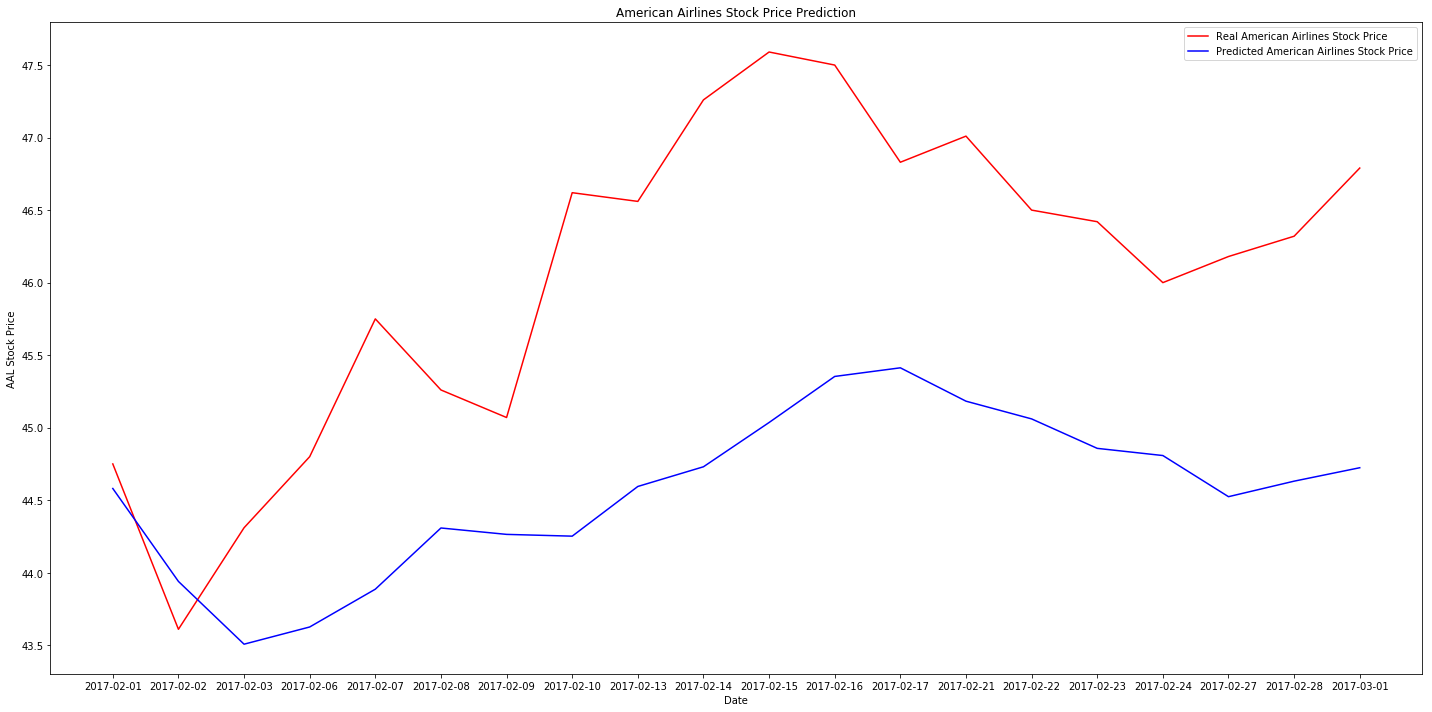

In [19]:
# Visualising the results
import seaborn as sns
plt.figure(figsize = (20,10))
plt.plot(AirLineOil_Test['AAL'].values, color = 'red', label = 'Real American Airlines Stock Price')
plt.plot(predicted_stock_price[0], color = 'blue', label = 'Predicted American Airlines Stock Price')
plt.title('American Airlines Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('AAL Stock Price')
plt.legend()
plt.tight_layout()
plt.savefig("Result.png")
plt.show()
